In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('iteration 4').getOrCreate()
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import groupby
from operator import itemgetter

In [2]:
#Load Data
changping_data = spark.read.load('./CP_data.csv', inferSchema=True, format = 'csv', header = 'true')

In [3]:
#Let's get an idea of what the data looks like
changping_data.show(10)
changping_data.printSchema()
changping_data.count()

+---+----+-----+---+----+-----+----+----+----+---+----+----+------+-----+----+---+----+---------+
| No|year|month|day|hour|PM2.5|PM10| SO2| NO2| CO|  O3|TEMP|  PRES| DEWP|RAIN| wd|WSPM|  station|
+---+----+-----+---+----+-----+----+----+----+---+----+----+------+-----+----+---+----+---------+
|  1|2013|    3|  1|   0|  3.0| 6.0|13.0| 7.0|300|85.0|-2.3|1020.8|-19.7| 0.0|  E| 0.5|Changping|
|  2|2013|    3|  1|   1|  3.0| 3.0| 6.0| 6.0|300|85.0|-2.5|1021.3|-19.0| 0.0|ENE| 0.7|Changping|
|  3|2013|    3|  1|   2|  3.0| 3.0|22.0|13.0|400|74.0|-3.0|1021.3|-19.9| 0.0|ENE| 0.2|Changping|
|  4|2013|    3|  1|   3|  3.0| 6.0|12.0| 8.0|300|81.0|-3.6|1021.8|-19.1| 0.0|NNE| 1.0|Changping|
|  5|2013|    3|  1|   4|  3.0| 3.0|14.0| 8.0|300|81.0|-3.5|1022.3|-19.4| 0.0|  N| 2.1|Changping|
|  6|2013|    3|  1|   5|  3.0| 3.0|10.0|17.0|400|71.0|-4.5|1022.6|-19.5| 0.0|NNW| 1.7|Changping|
|  7|2013|    3|  1|   6|  4.0| 6.0|12.0|22.0|500|65.0|-4.5|1023.4|-19.5| 0.0|NNW| 1.8|Changping|
|  8|2013|    3|  1|

35064

In [4]:
#We change the name 'PM2.5' to 'PM' to avoid the problem caused by the decimal point
changping_data = changping_data.withColumnRenamed('PM2.5', 'PM')
changping_data = changping_data.toPandas()
print(changping_data.info())
print(changping_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
No         35064 non-null int64
year       35064 non-null int64
month      35064 non-null int64
day        35064 non-null int64
hour       35064 non-null int64
PM         34290 non-null float64
PM10       34482 non-null float64
SO2        34436 non-null float64
NO2        34397 non-null float64
CO         33543 non-null float64
O3         34460 non-null float64
TEMP       35011 non-null float64
PRES       35014 non-null float64
DEWP       35011 non-null float64
RAIN       35013 non-null float64
wd         34924 non-null object
WSPM       35021 non-null float64
station    35064 non-null object
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB
None
                 No          year         month           day          hour  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean   17532.500000   2014.662560      6.522930     15.729637    

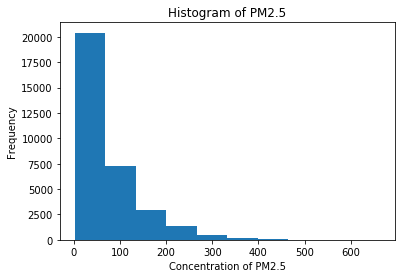

In [5]:
fig,ax = plt.subplots()
#Histogram
ax.hist(changping_data.dropna()['PM'])
ax.set_title('Histogram of PM2.5')
ax.set_xlabel('Concentration of PM2.5')
ax.set_ylabel('Frequency')
plt.show()
plt.close()

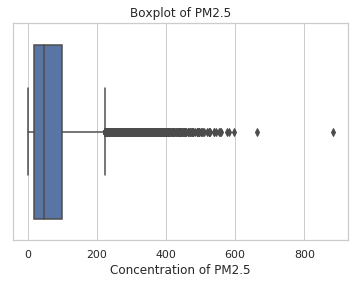

In [6]:
#Boxplot
sns.set(style="whitegrid")
ax = sns.boxplot("PM", data = changping_data)
ax.set_title('Boxplot of PM2.5')
ax.set_xlabel('Concentration of PM2.5')
plt.show()
plt.close()

In [7]:
#Correlation
corr1 = changping_data.corr(method = 'pearson')["PM"]
corr2 = changping_data.corr(method = 'kendall')["PM"]
print(corr1)
print(corr2)

No      -0.055526
year    -0.050985
month   -0.014502
day     -0.001083
hour     0.032928
PM       1.000000
PM10     0.864126
SO2      0.457297
NO2      0.673752
CO       0.766785
O3      -0.097806
TEMP    -0.109540
PRES     0.007180
DEWP     0.117907
RAIN    -0.008525
WSPM    -0.272908
Name: PM, dtype: float64
No      -0.046999
year    -0.052859
month   -0.001426
day      0.008621
hour     0.026005
PM       1.000000
PM10     0.726223
SO2      0.307762
NO2      0.466198
CO       0.642305
O3      -0.150420
TEMP    -0.023199
PRES    -0.035758
DEWP     0.144642
RAIN    -0.003724
WSPM    -0.226637
Name: PM, dtype: float64


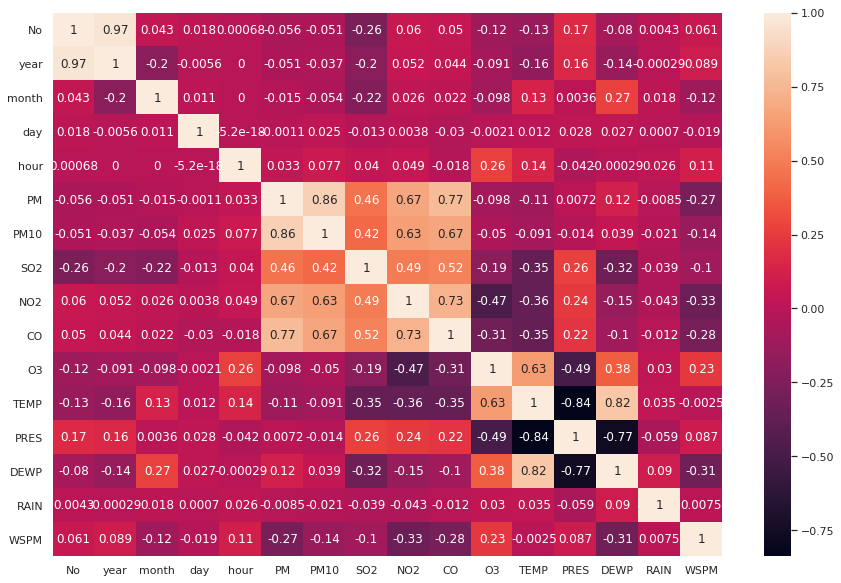

In [8]:
#Use heatmap to show the correlations
corr_all = changping_data.corr(method = 'pearson')
fig = plt.figure(figsize=(15,10))
sns.heatmap(corr_all, annot=True)

In [9]:
#Check the distribution of missing data
print(changping_data.isnull().sum().sort_values(ascending = False))
print(changping_data.isnull().sum().sort_values(ascending = False)/len(changping_data))

CO         1521
PM          774
NO2         667
SO2         628
O3          604
PM10        582
wd          140
DEWP         53
TEMP         53
RAIN         51
PRES         50
WSPM         43
month         0
year          0
station       0
day           0
hour          0
No            0
dtype: int64
CO         0.043378
PM         0.022074
NO2        0.019022
SO2        0.017910
O3         0.017226
PM10       0.016598
wd         0.003993
DEWP       0.001512
TEMP       0.001512
RAIN       0.001454
PRES       0.001426
WSPM       0.001226
month      0.000000
year       0.000000
station    0.000000
day        0.000000
hour       0.000000
No         0.000000
dtype: float64


In [10]:
#How many rows have at least 1 missing value and check the probability of the rows that having missing value
missing_row_num = sum(changping_data.apply(lambda x: sum(x.isnull().values), axis = 1)>0)
print(missing_row_num)
print(missing_row_num/len(changping_data))

2383
0.06796144193474789


In [11]:
#Deal with the missing data, first for "wd"
mod_df = changping_data.dropna( how='any',subset=['wd'])
print(mod_df.isnull().sum().sort_values(ascending = False))

#Delete all rows have continuous missing values
missing_row_co = np.where(mod_df['CO'].isnull() == True)[0].tolist()
lst_1 = []
lst_2 = []
for k, g in groupby(enumerate(missing_row_co), lambda ix : ix[0] - ix[1]):
    lst_1.append(list(map(itemgetter(1), g)))
for j in lst_1:
    if len(j) >= 2:
        lst_2.append(j)
   
lst_total_unlist = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, lst_2) for i in b]
mod_df = mod_df.drop(mod_df.index[lst_total_unlist])
print(mod_df.isnull().sum().sort_values(ascending = False))

lst_1 = []
lst_2 = []
missing_row_pm25 = np.where(mod_df['PM'].isnull() == True)[0].tolist()
for k, g in groupby(enumerate(missing_row_pm25), lambda ix : ix[0] - ix[1]):
    lst_1.append(list(map(itemgetter(1), g)))
for j in lst_1:
    if len(j) >= 2:
        lst_2.append(j)
lst_total_unlist = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, lst_2) for i in b]
mod_df = mod_df.drop(mod_df.index[lst_total_unlist])
print(mod_df.isnull().sum().sort_values(ascending = False))

lst_1 = []
lst_2 = []
missing_row_NO2 = np.where(mod_df['NO2'].isnull() == True)[0].tolist()
for k, g in groupby(enumerate(missing_row_NO2), lambda ix : ix[0] - ix[1]):
    lst_1.append(list(map(itemgetter(1), g)))
for j in lst_1:
    if len(j) >= 2:
        lst_2.append(j)
lst_total_unlist = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, lst_2) for i in b]
mod_df = mod_df.drop(mod_df.index[lst_total_unlist])

lst_1 = []
lst_2 = []
missing_row_SO2 = np.where(mod_df['SO2'].isnull() == True)[0].tolist()
for k, g in groupby(enumerate(missing_row_SO2), lambda ix : ix[0] - ix[1]):
    lst_1.append(list(map(itemgetter(1), g)))
for j in lst_1:
    if len(j) >= 2:
        lst_2.append(j)
lst_total_unlist = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, lst_2) for i in b]
mod_df = mod_df.drop(mod_df.index[lst_total_unlist])

lst_1 = []
lst_2 = []
missing_row_O3 = np.where(mod_df['O3'].isnull() == True)[0].tolist()
for k, g in groupby(enumerate(missing_row_O3), lambda ix : ix[0] - ix[1]):
    lst_1.append(list(map(itemgetter(1), g)))
for j in lst_1:
    if len(j) >= 2:
        lst_2.append(j)
lst_total_unlist = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, lst_2) for i in b]
mod_df = mod_df.drop(mod_df.index[lst_total_unlist])


lst_1 = []
lst_2 = []
missing_row_O3 = np.where(mod_df['WSPM'].isnull() == True)[0].tolist()
for k, g in groupby(enumerate(missing_row_O3), lambda ix : ix[0] - ix[1]):
    lst_1.append(list(map(itemgetter(1), g)))
for j in lst_1:
    if len(j) >= 2:
        lst_2.append(j)
lst_total_unlist = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, lst_2) for i in b]
mod_df = mod_df.drop(mod_df.index[lst_total_unlist])

lst_1 = []
lst_2 = []
missing_row_O3 = np.where(mod_df['PM10'].isnull() == True)[0].tolist()
for k, g in groupby(enumerate(missing_row_O3), lambda ix : ix[0] - ix[1]):
    lst_1.append(list(map(itemgetter(1), g)))
for j in lst_1:
    if len(j) >= 2:
        lst_2.append(j)
lst_total_unlist = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, lst_2) for i in b]
mod_df = mod_df.drop(mod_df.index[lst_total_unlist])

lst_1 = []
lst_2 = []
missing_row_O3 = np.where(mod_df['DEWP'].isnull() == True)[0].tolist()
for k, g in groupby(enumerate(missing_row_O3), lambda ix : ix[0] - ix[1]):
    lst_1.append(list(map(itemgetter(1), g)))
for j in lst_1:
    if len(j) >= 2:
        lst_2.append(j)
lst_total_unlist = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, lst_2) for i in b]
mod_df = mod_df.drop(mod_df.index[lst_total_unlist])


lst_1 = []
lst_2 = []
missing_row_O3 = np.where(mod_df['TEMP'].isnull() == True)[0].tolist()
for k, g in groupby(enumerate(missing_row_O3), lambda ix : ix[0] - ix[1]):
    lst_1.append(list(map(itemgetter(1), g)))
for j in lst_1:
    if len(j) >= 2:
        lst_2.append(j)
lst_total_unlist = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, lst_2) for i in b]
mod_df = mod_df.drop(mod_df.index[lst_total_unlist])
print(mod_df.isnull().sum().sort_values(ascending = False))

CO         1519
PM          771
NO2         666
SO2         627
O3          603
PM10        580
DEWP         10
TEMP         10
RAIN          8
PRES          7
day           0
year          0
month         0
station       0
hour          0
WSPM          0
wd            0
No            0
dtype: int64
PM         399
NO2        280
CO         239
PM10       235
O3         223
SO2        217
DEWP        10
TEMP        10
RAIN         8
PRES         7
day          0
year         0
month        0
station      0
hour         0
WSPM         0
wd           0
No           0
dtype: int64
NO2        264
CO         232
O3         210
SO2        203
PM         116
PM10       100
DEWP        10
TEMP        10
RAIN         8
PRES         7
day          0
year         0
month        0
station      0
hour         0
WSPM         0
wd           0
No           0
dtype: int64
CO         223
NO2        143
O3         139
PM         104
SO2        101
PM10        84
RAIN         7
DEWP         6
PRES         

In [12]:
#Reset the index of each row

mod_df = mod_df.reset_index(drop=True)

C0_missing_lst = mod_df[mod_df['CO'].isnull()].index.tolist()
NO2_missing_lst = mod_df[mod_df['NO2'].isnull()].index.tolist()
O3_missing_lst = mod_df[mod_df['O3'].isnull()].index.tolist()
PM25_missing_lst = mod_df[mod_df['PM'].isnull()].index.tolist()
SO2_missing_lst = mod_df[mod_df['SO2'].isnull()].index.tolist()
WSPM_missing_lst = mod_df[mod_df['WSPM'].isnull()].index.tolist()
PM10_missing_lst = mod_df[mod_df['PM10'].isnull()].index.tolist()
DEWP_missing_lst = mod_df[mod_df['DEWP'].isnull()].index.tolist()
TEMP_missing_lst = mod_df[mod_df['TEMP'].isnull()].index.tolist()
RAIN_missing_lst = mod_df[mod_df['RAIN'].isnull()].index.tolist()
PRES_missing_lst = mod_df[mod_df['PRES'].isnull()].index.tolist()

for i in C0_missing_lst:
    mod_df.at[i,'CO'] = (mod_df.at[i-1,"CO"] + mod_df.at[i+1,"CO"])/2
for i in NO2_missing_lst:
    mod_df.at[i,'NO2'] = (mod_df.at[i-1,"NO2"] + mod_df.at[i+1,"NO2"])/2
for i in O3_missing_lst:
    mod_df.at[i,'O3'] = (mod_df.at[i-1,"O3"] + mod_df.at[i+1,"O3"])/2
for i in PM25_missing_lst:
    mod_df.at[i,'PM'] = (mod_df.at[i-1,"PM"] + mod_df.at[i+1,"PM"])/2
for i in SO2_missing_lst:
    mod_df.at[i,'SO2'] = (mod_df.at[i-1,"SO2"] + mod_df.at[i+1,"SO2"])/2
for i in WSPM_missing_lst:
    mod_df.at[i,'WSPM'] = (mod_df.at[i-1,"WSPM"] + mod_df.at[i+1,"WSPM"])/2
for i in PM10_missing_lst:
    mod_df.at[i,'PM10'] = (mod_df.at[i-1,"PM10"] + mod_df.at[i+1,"PM10"])/2
for i in DEWP_missing_lst:
    mod_df.at[i,'DEWP'] = (mod_df.at[i-1,"DEWP"] + mod_df.at[i+1,"DEWP"])/2
for i in TEMP_missing_lst:
    mod_df.at[i,'TEMP'] = (mod_df.at[i-1,"TEMP"] + mod_df.at[i+1,"TEMP"])/2
for i in RAIN_missing_lst:
    mod_df.at[i,'RAIN'] = (mod_df.at[i-1,"RAIN"] + mod_df.at[i+1,"RAIN"])/2
for i in PRES_missing_lst:
    mod_df.at[i,'PRES'] = (mod_df.at[i-1,"PRES"] + mod_df.at[i+1,"PRES"])/2

#Now check the dataset after dealing with the missing value
print(mod_df.isnull().sum().sort_values(ascending = False))
print(mod_df.shape)

station    0
WSPM       0
year       0
month      0
day        0
hour       0
PM         0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
No         0
dtype: int64
(33075, 18)


In [13]:
#Step 3.4 integrate two different dataset into one        
#sub_dataset_1 = spark.read.load('./sub_dataset_1.csv', inferSchema=True, format = 'csv', header = 'true')
#sub_dataset_1 = sub_dataset_1.withColumnRenamed('PM2.5', 'PM').toPandas()
#sub_dataset_1.info()

#print('\n')
#sub_dataset_2 = spark.read.load('./sub_dataset_2.csv', inferSchema=True, format = 'csv', header = 'true')
#sub_dataset_2 = sub_dataset_2.withColumnRenamed('PM2.5', 'PM').toPandas()
#sub_dataset_2.info()

#print('\n')
#Combine two datasets into one
#changping_data_ = pd.concat([sub_dataset_1, sub_dataset_2], axis=1, join="inner")
#changping_data_.info()

In [14]:
#Step 4.1 select fearures
mod_df.drop(['wd'], axis = 1, inplace=True)    
mod_df.drop(['No','year','station','PM10'], axis = 1, inplace=True)
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33075 entries, 0 to 33074
Data columns (total 13 columns):
month    33075 non-null int64
day      33075 non-null int64
hour     33075 non-null int64
PM       33075 non-null float64
SO2      33075 non-null float64
NO2      33075 non-null float64
CO       33075 non-null float64
O3       33075 non-null float64
TEMP     33075 non-null float64
PRES     33075 non-null float64
DEWP     33075 non-null float64
RAIN     33075 non-null float64
WSPM     33075 non-null float64
dtypes: float64(10), int64(3)
memory usage: 3.3 MB


In [15]:
#SeletKBest features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV

column_lst = mod_df.columns.tolist()
no_need_col = ["PM","No","year","station","PM10"]
valid_lst = [e for e in column_lst if e not in no_need_col]

get_top10 = SelectKBest(score_func = f_regression,k = 10)
fitting_res = get_top10.fit(mod_df[valid_lst],mod_df["PM"])

var_score_df = pd.concat([pd.DataFrame(valid_lst), pd.DataFrame(fitting_res.scores_)], axis = 1)
var_score_df.columns = ["Var","Correlation_Score"]

#See the top 10 relevant variables with concentration of PM2.5
print(var_score_df.nlargest(10,"Correlation_Score"))

      Var  Correlation_Score
5      CO       47019.123067
4     NO2       28249.567047
3     SO2        9454.755353
11   WSPM        2705.636309
7    TEMP         434.310426
9    DEWP         417.578413
6      O3         306.260173
2    hour          34.349237
0   month          18.193941
10   RAIN           5.583805


In [16]:
#Extract the final dataset we'll use

valid_lst_final = ['PM', 'CO', 'NO2', 'SO2', 'WSPM', 'TEMP', 'DEWP', 'O3', 'hour', 'month']
df = mod_df[valid_lst_final]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33075 entries, 0 to 33074
Data columns (total 10 columns):
PM       33075 non-null float64
CO       33075 non-null float64
NO2      33075 non-null float64
SO2      33075 non-null float64
WSPM     33075 non-null float64
TEMP     33075 non-null float64
DEWP     33075 non-null float64
O3       33075 non-null float64
hour     33075 non-null int64
month    33075 non-null int64
dtypes: float64(8), int64(2)
memory usage: 2.5 MB


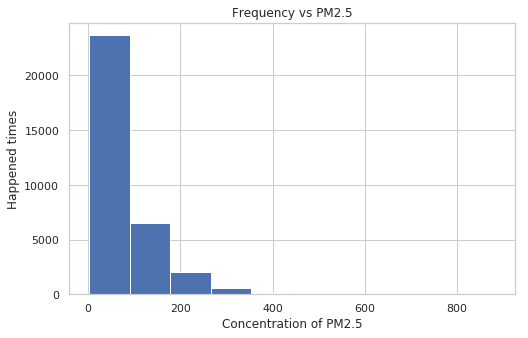

In [17]:
#4.2 projected the data
df.hist('PM',figsize = (8,5))
plt.title("Frequency vs PM2.5")
plt.ylabel("Happened times")
plt.xlabel("Concentration of PM2.5")
plt.show()
plt.close()

/home/ubuntu/.local/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


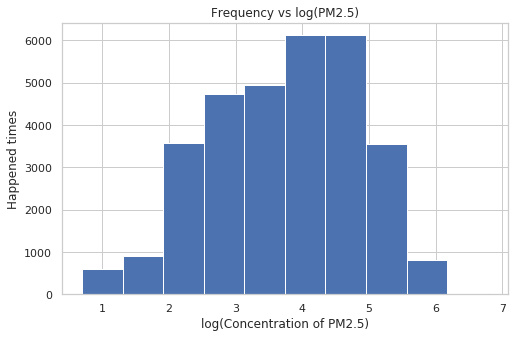

In [18]:
#log transformation
#TEMP and DEWP has some negative values


df.TEMP = df.TEMP+ (abs(min(df["TEMP"]))+1)
df.DEWP = df.DEWP+ (abs(min(df["DEWP"]))+1)
df_log = df.apply(lambda x: np.log(x))
df_log = df_log[~df_log.isin([np.nan, np.inf, -np.inf]).any(1)]

#Check the distribution again
df_log.hist('PM',figsize = (8,5))
plt.title("Frequency vs log(PM2.5)")
plt.ylabel("Happened times")
plt.xlabel("log(Concentration of PM2.5)")
plt.show()
plt.close()

In [19]:
#Convert the data to dense vector (features and label)
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['CO', 'NO2', 'SO2', 'WSPM', 'TEMP', 'DEWP', 'O3', 'hour', 'month'],
    outputCol="features")
output = assembler.transform(spark.createDataFrame(df_log))
output.printSchema()
df_final = output.select("features",'PM')
df_final.head()

root
 |-- PM: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- WSPM: double (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- hour: double (nullable = true)
 |-- month: double (nullable = true)
 |-- features: vector (nullable = true)



Row(features=DenseVector([5.7038, 1.7918, 1.7918, -0.3567, 2.7147, 2.8391, 4.4427, 0.0, 1.0986]), PM=1.0986122886681098)

In [20]:
#7.1 split the training and test set
training_set, test_set = df_final.randomSplit([0.7,0.3])

In [21]:
#7.2 Run the DM algorithm
#1.Linear Regression
#x_train, y_train = training_set.iloc[:,1:10], training_set.iloc[:,0]
#x_test, y_test = test_set.iloc[:,1:10], test_set.iloc[:,0]
from pyspark.ml.regression import LinearRegression

linear_regression = LinearRegression(featuresCol="features", labelCol='PM', predictionCol = 'prediction')
LineaeRegression_Model = linear_regression.fit(training_set)
LinearRegression_predictions = LineaeRegression_Model.transform(test_set)
#Check whether the model can get the prediction successfully
LinearRegression_predictions.select("prediction","PM").show(5)
print('\n')

print("Intercept: {}".format(LineaeRegression_Model.intercept))
col = ['CO', 'NO2', 'SO2', 'WSPM', 'TEMP', 'DEWP', 'O3', 'hour', 'month']
df_LR = pd.DataFrame({'Attributes': col, 'Coefficient': LineaeRegression_Model.coefficients,})

print(df_LR)
test_res = LineaeRegression_Model.evaluate(test_set)
print('\n')
print('Linear Regression')
print("RSME: ", test_res.rootMeanSquaredError)
print("R2: ", test_res.r2)


+------------------+------------------+
|        prediction|                PM|
+------------------+------------------+
|1.2782101547665805|2.1972245773362196|
|0.5605853431374124|2.0794415416798357|
|1.3989363315876853|1.9459101490553132|
|1.4664302913995195|2.1972245773362196|
|1.4986423702508969|2.3978952727983707|
+------------------+------------------+
only showing top 5 rows



Intercept: -6.134278583553783
  Attributes  Coefficient
0         CO     0.866922
1        NO2     0.286607
2        SO2     0.122283
3       WSPM    -0.006659
4       TEMP     0.022177
5       DEWP     0.712942
6         O3     0.092548
7       hour     0.000600
8      month    -0.085036


Linear Regression
RSME:  0.5908129974020359
R2:  0.7155413436918414


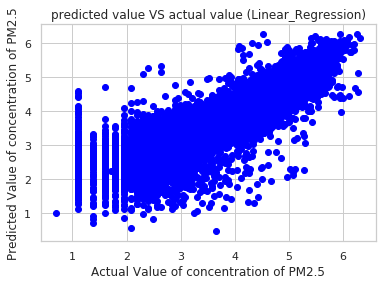

In [22]:
#Draw the graph of the prediction versus actual value of the Linear regression model
pred_LinearRegression = LinearRegression_predictions.toPandas()
plt.plot(pred_LinearRegression['PM'],pred_LinearRegression['prediction'], 'o', color='blue') 
plt.xlabel('Actual Value of concentration of PM2.5')
plt.ylabel('Predicted Value of concentration of PM2.5')
plt.title('predicted value VS actual value (Linear_Regression)')
plt.show()
plt.close()

In [23]:
#RandomForest

In [24]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

RandomForest = RandomForestRegressor(featuresCol="features", labelCol = 'PM')
RandomForest_model = RandomForest.fit(training_set)

RandomForest_predictions = RandomForest_model.transform(test_set)
evaluator = RegressionEvaluator(
    labelCol="PM", predictionCol="prediction")

RandomForest_predictions.select("prediction","PM").show(5)
print('\n')

RF_feature_importance = pd.DataFrame({'Feature_Importance': RandomForest_model.featureImportances, 'attributes': col})
RF_feature_importance.sort_values(by=['Feature_Importance'], inplace=True, ascending=False)

print('number of trees:', RandomForest_model.getNumTrees)
print(RF_feature_importance)
print('\n')
print('Random forest Regressor')
print('RMSE:', evaluator.evaluate(RandomForest_predictions, {evaluator.metricName: "rmse"}))
print('R2:', evaluator.evaluate(RandomForest_predictions, {evaluator.metricName: "r2"}))

+------------------+------------------+
|        prediction|                PM|
+------------------+------------------+
|2.6547522789739686|2.1972245773362196|
|2.3313260164216816|2.0794415416798357|
|2.6547522789739686|1.9459101490553132|
|2.6547522789739686|2.1972245773362196|
|2.8930155299513336|2.3978952727983707|
+------------------+------------------+
only showing top 5 rows



number of trees: 20
   Feature_Importance attributes
0            0.512498         CO
1            0.191796        NO2
2            0.085677        SO2
6            0.078604         O3
5            0.067314       DEWP
3            0.037020       WSPM
4            0.016808       TEMP
8            0.009197      month
7            0.001086       hour


Random forest Regressor
RMSE: 0.5683846165581699
R2: 0.7367285879321914


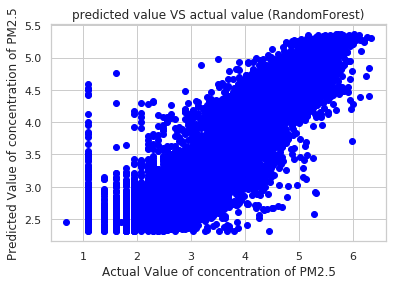

In [25]:
#Draw the graph of the prediction versus actual value of the Linear regression model

pred_RandomForest = RandomForest_predictions.toPandas()
plt.plot(pred_RandomForest['PM'],pred_RandomForest['prediction'], 'o', color='blue') 
plt.xlabel('Actual Value of concentration of PM2.5')
plt.ylabel('Predicted Value of concentration of PM2.5')
plt.title('predicted value VS actual value (RandomForest)')
plt.show()
plt.close()

In [26]:
from pyspark.ml.regression import GBTRegressor

# Gradient-boosted tree regression model
gbt = GBTRegressor(featuresCol="features", labelCol='PM', maxIter=20)
gbt_Model = gbt.fit(training_set)
gbt_predictions = gbt_Model.transform(test_set)
gbt_evaluator = RegressionEvaluator(
    labelCol="PM", predictionCol="prediction")

gbt_predictions.select("prediction","PM").show(5)
print('\n')

#Check the feature importance
gbt_feature_importance = pd.DataFrame({ 'Feature_Importance': gbt_Model.featureImportances, 'attributes': col})
gbt_feature_importance.sort_values(by=['Feature_Importance'], inplace=True, ascending=False)
print(gbt_feature_importance)

print('\n')
print('Gradient-boosted Tree')
print('RMSE:', gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "rmse"}))
print('R2:', gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "r2"}))


+------------------+------------------+
|        prediction|                PM|
+------------------+------------------+
| 2.054814320048816|2.1972245773362196|
|2.1511125881515674|2.0794415416798357|
|1.9630594843907219|1.9459101490553132|
| 1.923387136909024|2.1972245773362196|
| 2.379477608575068|2.3978952727983707|
+------------------+------------------+
only showing top 5 rows



   Feature_Importance attributes
0            0.254975         CO
5            0.151797       DEWP
1            0.137238        NO2
6            0.121707         O3
8            0.097456      month
4            0.076278       TEMP
2            0.073679        SO2
7            0.055940       hour
3            0.030931       WSPM


Gradient-boosted Tree
RMSE: 0.5054474581716346
R2: 0.7918046112413206


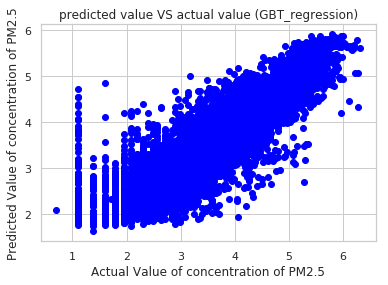

In [27]:
#Draw the graph of the prediction versus actual value of the Gradient-boosted tree regression model

pred_gbt = gbt_predictions.toPandas()
plt.plot(pred_gbt['PM'],pred_gbt['prediction'], 'o', color='blue') 
plt.xlabel('Actual Value of concentration of PM2.5')
plt.ylabel('Predicted Value of concentration of PM2.5')
plt.title('predicted value VS actual value (GBT_regression)')
plt.show()
plt.close()

In [28]:
#Comparison
print('\n')
algo_lst = ['Linear_Regression','RandomForest','Gradient-boosted Tree']
rmse_lst = [test_res.rootMeanSquaredError, evaluator.evaluate(RandomForest_predictions, {evaluator.metricName: "rmse"}), gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "rmse"})]
R2_lst = [test_res.r2, evaluator.evaluate(RandomForest_predictions, {evaluator.metricName: "r2"}), gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "r2"})]
compare_df = pd.DataFrame({'Algorithm':algo_lst, 'RMSE':rmse_lst, 'R^2 score':R2_lst})
print(compare_df)



               Algorithm      RMSE  R^2 score
0      Linear_Regression  0.590813   0.715541
1           RandomForest  0.568385   0.736729
2  Gradient-boosted Tree  0.505447   0.791805
